In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
weather_df = pd.read_csv("weather-2.csv", names=["station", "date", "latitude", "longitude", "elevation", "tmax"])
weather_df.head()
# weather-2.csv is the csv file for tmax-2
weather_df

station        date  latitude  longitude  elevation  tmax
0       ASN00037051  1989-01-15  -22.3908   143.0386      181.9  38.7
1       USC00181862  1991-12-04   39.2553   -76.9286      112.8   8.3
2       USS0009E08S  2016-10-13   44.8000  -109.6600     2331.7  13.6
3       MLM00061257  1976-03-06   14.4820   -11.4400       51.5  37.0
4       USC00021001  1936-05-13   36.2147  -112.0620     2438.4  20.0
...             ...         ...       ...        ...        ...   ...
180659  USC00300889  1937-09-27   40.9519   -72.2981       12.8  16.7
180660  USC00352135  1953-12-21   42.9447  -117.3389     1287.8   2.8
180661  USC00460580  1939-12-30   37.7647   -81.1939      710.2  -2.2
180662  CA002100181  2017-09-20   61.3667  -139.0333      805.0  13.2
180663  USC00213200  1919-09-13   48.3167   -95.8833      353.6  23.3

[180664 rows x 6 columns]

In [3]:
weather_df_agg = weather_df.groupby(['station']).agg({'tmax':'mean', 'latitude':'first', 'longitude' :'first'})

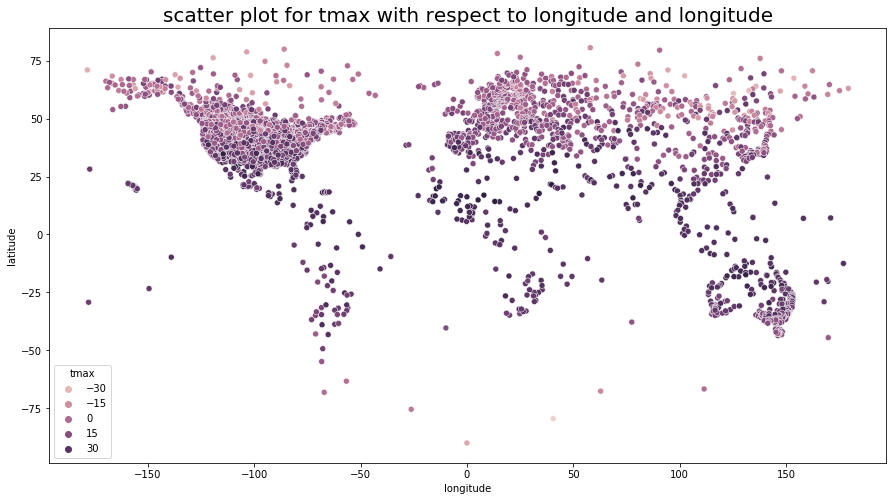

In [4]:
# Part a: Produce one or more figures that illustrate the daily max
plt.figure(figsize=(15,8))
plt.title('scatter plot for tmax with respect to longitude and longitude', fontsize=20)
sns.scatterplot(data=weather_df_agg, x="longitude", y="latitude", hue = "tmax")
plt.show()

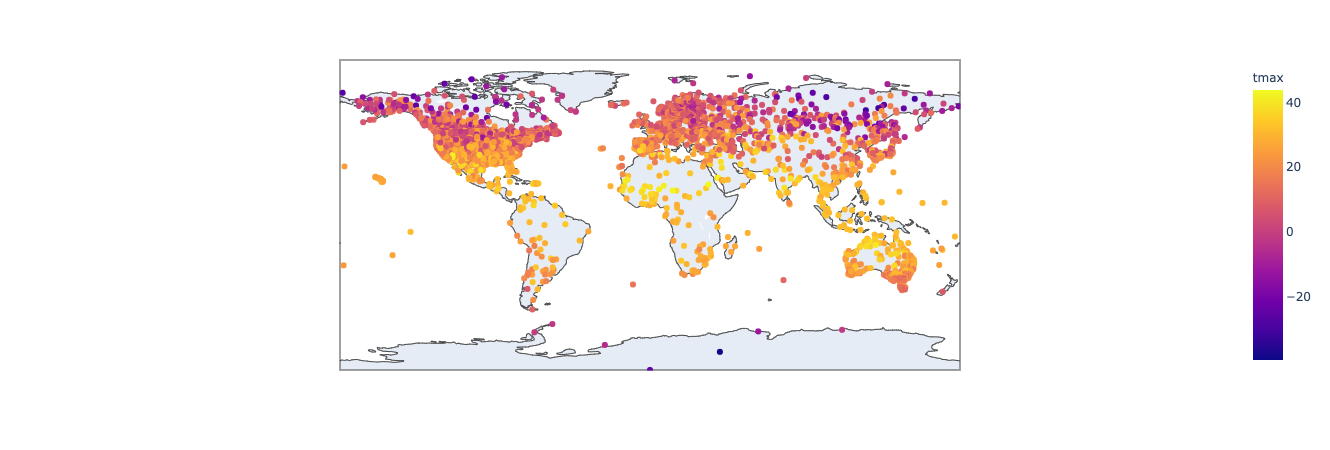

In [5]:
fig = px.scatter_geo(weather_df_agg,
                    lat="latitude",
                    lon="longitude",
                    hover_name="tmax", 
                    color="tmax")
fig.show()

In [5]:
# part B
# my model is trained on tmax-3 dataset
# prediction.csv is the result of apply the new model to the test data
prediction_df = pd.read_csv("prediction.csv")
prediction_df_1 = prediction_df[['dayOfYear', 'tmax','prediction']]
prediction_df_2 = prediction_df[['longitude', 'latitude','prediction']]
prediction_df_1['residual'] = prediction_df_1['tmax'] - prediction_df_1['prediction']
prediction_df.head()

/Users/zhangchao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Unnamed: 0  latitude  longitude  elevation  tmax  dayOfYear  \
0           0   58.4167  -130.0333      793.0 -21.5        362   
1           1   52.7000   141.3000        5.0  -9.5        331   
2           2   50.1667  -114.7000     2130.0  -7.2         64   
3           3   43.1833   -80.4500      259.0   1.7         94   
4           4   49.7500    30.1170      180.0  11.0         81   

                                            features  prediction  
0  [58.41669845581055,-130.03329467773438,793.0,3...   -4.680403  
1    [52.70000076293945,141.3000030517578,5.0,331.0]  -13.364421  
2  [50.16669845581055,-114.69999694824219,2130.0,...   -1.960488  
3  [43.18330001831055,-80.44999694824219,259.0,94.0]   13.938978  
4              [49.75,30.117000579833984,180.0,81.0]    4.826997

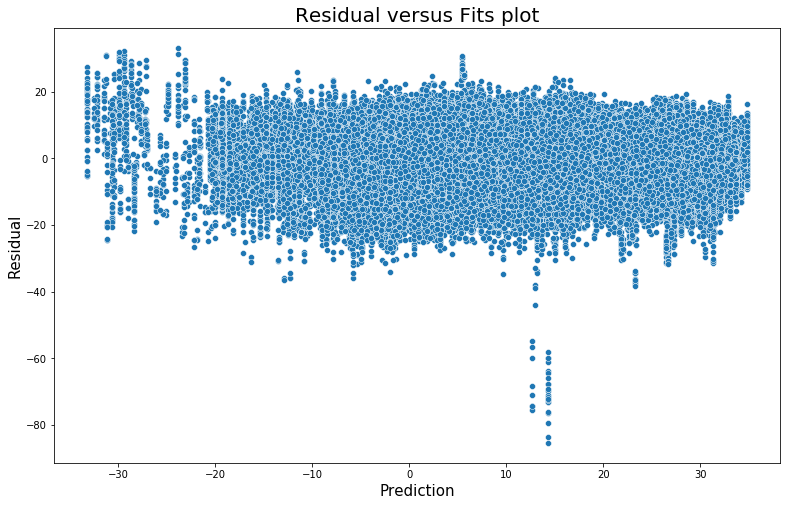

In [6]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=prediction_df_1, x="prediction", y="residual")
plt.title('Residual versus Fits plot', fontsize=20)
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Residual', fontsize=15)
plt.show()

##### Comment on the above residual plot:
My model is trained on tmax-3 dataset and the above residual plot is by applying my model to the test data.


For the most part, the plot shows a random pattern around the 0 line which means our model is a suitable fit. However, there exists some outliers. Also, the gap on the vertical axis is large (plus minus 20)

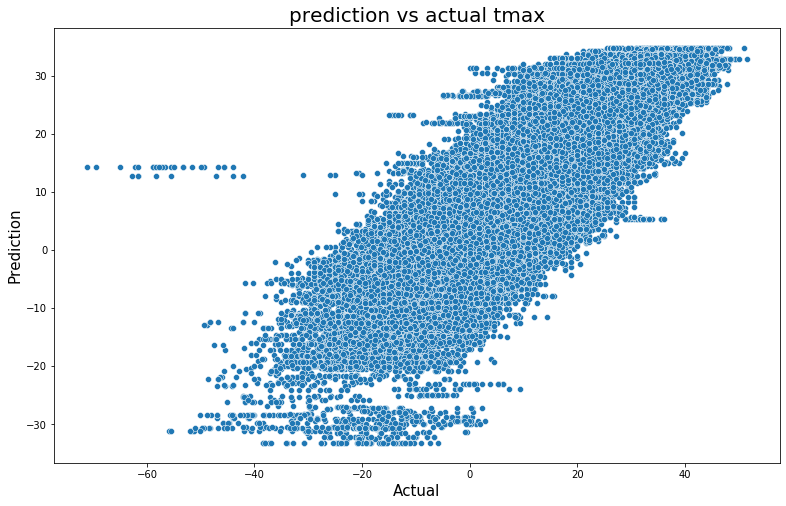

In [7]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=prediction_df_1, x="tmax", y="prediction")
plt.title('prediction vs actual tmax', fontsize=20)
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Prediction', fontsize=15)
plt.show()

##### The above plot is prediction vs actual tmax.
Most of the points are centered around on the y = x line. However, there are some outliers. 

Below are r2 and rmse for my model:

r2 = 0.7835359066462216
rmse = 6.03483144532603

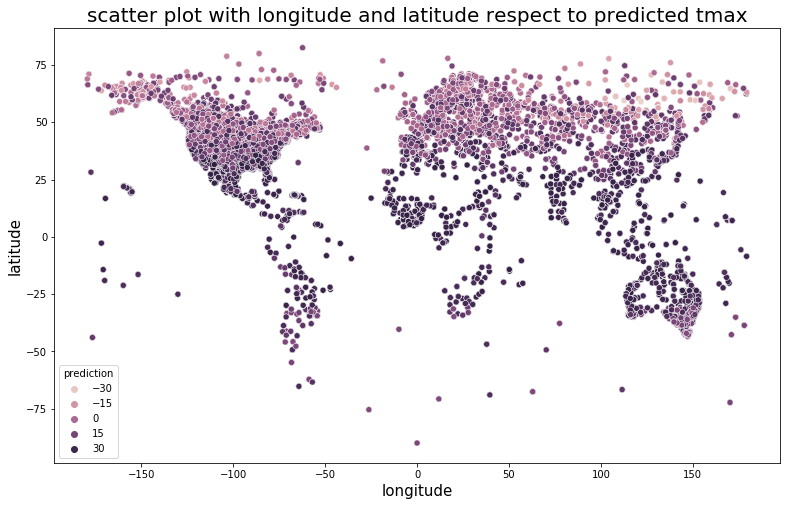

In [8]:
plt.figure(figsize=(13,8))
plt.title('scatter plot with longitude and latitude respect to predicted tmax', fontsize=20)
plt.xlabel('longitude', fontsize=15)
plt.ylabel('latitude', fontsize=15)
sns.scatterplot(data=prediction_df_2, x="longitude", y="latitude", hue = "prediction")
plt.show()

In [9]:
def heatmap_bins(data, fieldsxy, ncuts=30, aggarg='mean'):
    """Perform data.groupby using bin cuts along columns named in fieldsxy.
    Args:
        data     - pandas dataframe
        fieldsxy - list of column names along which to perform binned groupby
        ncuts    - number of cuts to perform for each field (see pd.cut)
        aggarg   - aggregation operation to perform, default: 'mean'
    Returns:
        grouped dataframe, ready for plotting via sns.heatmap(means['COLUMNAME'])
    """
    # based on: https://matthewmcgonagle.github.io/blog/2019/01/22/HeatmapBins
    cuts = pd.DataFrame({str(feature) + ' bins' : pd.cut(data[feature], ncuts) for feature in fieldsxy})
    means = data.join(cuts).groupby( list(cuts) ).agg(aggarg)
    means = means.unstack(level = 0) # Use level 0 to put 0Bin as columns.
    # Reverse the order of the rows as the heatmap will print from top to bottom.
    means = means.iloc[::-1]
    return means

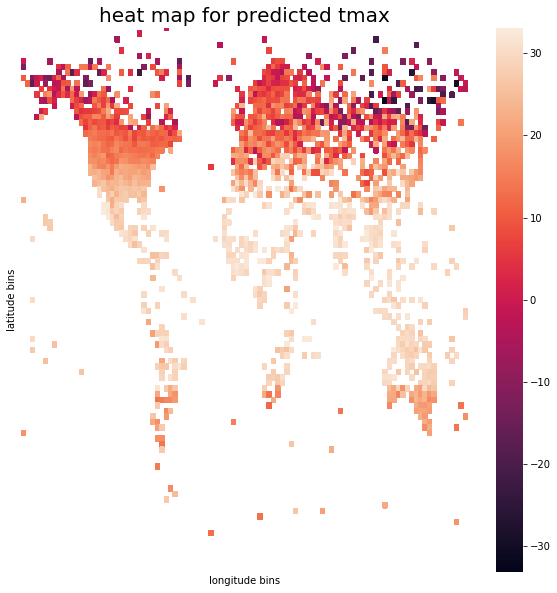

In [10]:
field = 'prediction'
means = heatmap_bins(prediction_df_2, ["longitude", "latitude"], ncuts=100)
with plt.rc_context({'figure.figsize': (10,10)}):
    plt.title('heat map for predicted tmax', fontsize=20)
    sns.heatmap(means[field])
plt.xticks([], []);
plt.yticks([], []);

The above heat map is for predicted tmax on test set

#### part b1

In [6]:
import elevation_grid as eg
el = eg.get_elevation(50, -123.1)
print("A place near Whistler, BC is {} m above sea level".format(el))

A place near Whistler, BC is 946.0 m above sea level


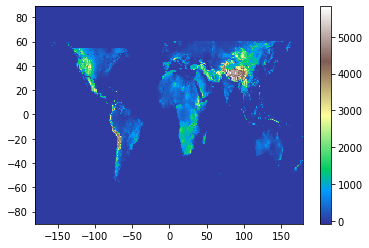

In [7]:
lats, lons = np.meshgrid(np.arange(-90,90,1),np.arange(-180,180,1))
elevs = [eg.get_elevations(np.array([late,lone]).T) for late,lone in zip(lats,lons)]
plt.pcolormesh(lons,lats,elevs,cmap='terrain')
plt.colorbar()
plt.show()

In [11]:
# b1-output.csv is the model prediction based on above latitude, longitude, elevation, and a specific date.
b1_df = pd.read_csv("b1-output.csv")
b1_df_1 = b1_df[["latitude", "longitude", "prediction"]]
b1_df_1.head()

latitude  longitude  prediction
0     -58.0     -136.0   24.234994
1     -57.5     -136.0   24.234994
2     -57.0     -136.0   24.234994
3     -56.5     -136.0   24.234994
4     -56.0     -136.0   24.234994

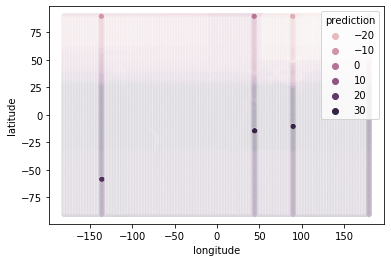

In [ ]:
sns.scatterplot(data=b1_df_1, x="longitude", y="latitude", hue = "prediction", palette="deep")

Above plot is for b1 which is a scatter plot for predicted tmax with respect longitude and latitude. I know the plot is confusing, I think it's because we have all the longitude and latitude, and many values are overlapping. 

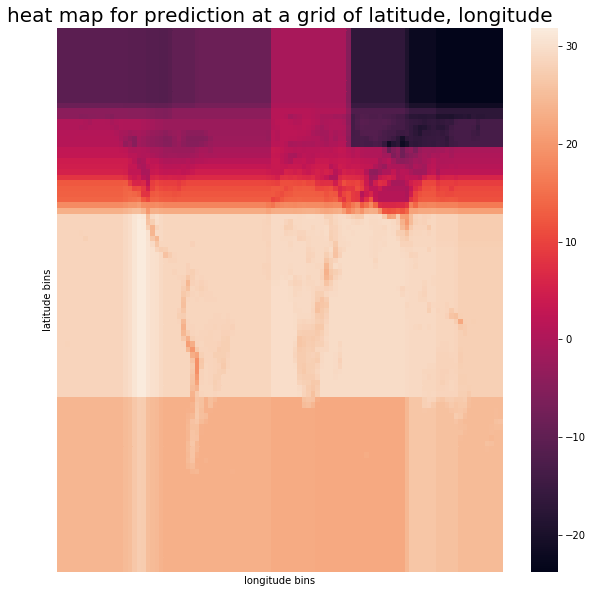

In [20]:
field = 'prediction'
means = heatmap_bins(b1_df_1, ["longitude", "latitude"], ncuts=100)
with plt.rc_context({'figure.figsize': (10,10)}):
    plt.title('heat map for prediction at a grid of latitude, longitude', fontsize=20)
    sns.heatmap(means[field])
plt.xticks([], []);
plt.yticks([], []);

In [ ]:
test_lats = lats.flatten()
test_lats.shape
test_lons = lons.flatten()

test_elevs = []
for sublist in elevs:
    for item in sublist:
        test_elevs.append(item)

In [ ]:
d = {'latitude': test_lats, 'longitude': test_lons, 'elevation': test_elevs}
df = pd.DataFrame(data=d)

In [ ]:
df['date'] = '1991-12-04'
df['tmax'] = 20.1
df['station'] = "CA001192345"

In [ ]:
df

latitude  longitude  elevation        date  tmax      station
0          -90.0     -180.0        0.0  1991-12-04  20.1  CA001192345
1          -89.5     -180.0        0.0  1991-12-04  20.1  CA001192345
2          -89.0     -180.0        0.0  1991-12-04  20.1  CA001192345
3          -88.5     -180.0        0.0  1991-12-04  20.1  CA001192345
4          -88.0     -180.0        0.0  1991-12-04  20.1  CA001192345
...          ...        ...        ...         ...   ...          ...
259195      87.5      179.5        0.0  1991-12-04  20.1  CA001192345
259196      88.0      179.5        0.0  1991-12-04  20.1  CA001192345
259197      88.5      179.5        0.0  1991-12-04  20.1  CA001192345
259198      89.0      179.5        0.0  1991-12-04  20.1  CA001192345
259199      89.5      179.5        0.0  1991-12-04  20.1  CA001192345

[259200 rows x 6 columns]